# ***Connect to Google Drive and load the dataset***

1.   If you havent already one ,Create a bew API Token from kaggle (A file named "kaggle.json" will be downloaded to your computer).

2.   Place "kaggle.json" in your google drive





In [ ]:
!pip install kaggle
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/"
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/dataset/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/dataset/test.csv')

# ***Take a Quick Look at the Data Structure***

In [ ]:
train_data.head()

In [ ]:
train_data.value_counts()

# ***Looking for Correlations***


In [ ]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

In [ ]:
from pandas.plotting import scatter_matrix
attributes = ["Survived", "Fare", "Parch",
 "SibSp","Age","Pclass"]
scatter_matrix(train_data[attributes], figsize=(6, 6))

# ***REPLACE MISSING VALUES WITH ANN***
Specifically, I created a regressor to predict age. To accomplish this, I utilized data from both the train and test sets, dropping the 'Survived','PassengerId' and 'Cabin' features. Subsequently, I divided the data into two sets: one containing records with age values (train set), and the other containing records without age values (test set).

In [3]:
# Connect train and test data to replace missing values
data = pd.concat([train_data, test_data], axis=0,ignore_index=True)
data=data.drop("Survived", axis=1)
data=data.drop("PassengerId", axis=1)

sex_encoder = OrdinalEncoder()
data['Sex']=sex_encoder.fit_transform(data[['Sex']])

## Embarked ##
mode_value=train_data["Embarked"].mode()[0]
data["Embarked"].fillna(mode_value, inplace=True)
Embarked_encoder=OneHotEncoder()
embarked_encoded =Embarked_encoder.fit_transform(data[['Embarked']])
Embarked=pd.DataFrame(embarked_encoded.toarray(), columns=Embarked_encoder.categories_[0])
data=pd.concat([data, Embarked],axis=1)
data=data.drop("Embarked", axis=1)

## Fare ##
mean_value=data['Fare'].mean()
data['Fare'].fillna(mean_value, inplace=True)

## Name ##
import re
def name_process(text):
  text = text.lower()
  text = re.findall(r"\b[a-z]+\.", text)
  text=text[0].strip()
  text = re.sub("[^ a-z]", "", text)

  return text

data['Title']= data['Name'].map(name_process)
data=data.drop("Name", axis=1)
title_counts=data['Title'].value_counts()
rare_titles=title_counts[title_counts == 1].index
data['Title'] = data['Title'].replace(rare_titles, 'rare')
Title_encoder = OneHotEncoder()
Title_encoded = Title_encoder.fit_transform(data[['Title']])
Title=pd.DataFrame(Title_encoded.toarray(), columns=Title_encoder.categories_[0])
data=pd.concat([data, Title],axis=1)
data=data.drop("Title", axis=1)

## TICKET ##

def ticket_number__process(text):
    match = re.search(r"\s(\d+)$", text)
    if match:
        number_str = match.group(1)
        try:
            number = int(number_str)
            return number
        except ValueError:
            pass
    try:
        number = int(text)
        return number
    except ValueError:
        return 0

## The idea here is to map every ticket to a number
## because families have probably the same ticket
## all tickets that own to a single person take 0 value
counts=data["Ticket"].map(ticket_number__process).value_counts()
r=counts[counts >1].rank(method="min", ascending=True)
def Ticket_process(r):
  temp=r.iloc[0]
  for i in range(1,r.shape[0]):
    r.iloc[i]=temp-1
    temp-=1
  return r
Ticket_process(r)
r=pd.concat([r,counts[counts ==1]-1])
data["Ticket"]=data["Ticket"].map(ticket_number__process).map(r)

data=data.drop("Cabin", axis=1)


In [4]:
# Split the dataset with respect of "nan" values ##
data_train = data[~data.isna().any(axis=1)]
data_test = data[data.isna().any(axis=1)]

Training_set=data_train
Test_set=data_test

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Label=Training_set['Age']
Training_set=Training_set.drop("Age", axis=1)
Test_set=Test_set.drop("Age", axis=1)

cs = MinMaxScaler()
trainContinuous = cs.fit_transform(Training_set)
testContinuous = cs.transform(Test_set)


train_x, val_x, train_y, val_y  = train_test_split(trainContinuous,Label, test_size=0.25, random_state=42)

maxAge = Label.max()
train_y = train_y / maxAge
val_y = val_y / maxAge

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,BatchNormalization,concatenate
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy as keras_legacy_optimizers
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf


checkpoint_callback = ModelCheckpoint(filepath='age_model.h5',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='min',
                                      verbose=1)


model = Sequential()
model.add(Dense(50, input_dim=20, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(20, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(20, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(10, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

epochs=500
opt = keras_legacy_optimizers.Adam(learning_rate=1e-3, decay=1e-3 / epochs)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

model.fit(x=train_x, y=train_y,
	validation_data=(val_x, val_y),
	epochs=epochs, batch_size=16,
	callbacks=[checkpoint_callback])


Epoch 1/500
40/49 [=======================>......] - ETA: 0s - loss: 238.6485
Epoch 1: val_loss improved from inf to 165.55190, saving model to age_model.h5
49/49 [==============================] - 2s 10ms/step - loss: 256.4639 - val_loss: 165.5519
Epoch 2/500
42/49 [========================>.....] - ETA: 0s - loss: 156.2520
Epoch 2: val_loss did not improve from 165.55190
49/49 [==============================] - 0s 4ms/step - loss: 144.1584 - val_loss: 175.9275
Epoch 3/500
41/49 [========================>.....] - ETA: 0s - loss: 89.7999
Epoch 3: val_loss improved from 165.55190 to 151.96407, saving model to age_model.h5
49/49 [==============================] - 0s 5ms/step - loss: 90.3964 - val_loss: 151.9641
Epoch 4/500
39/49 [======================>.......] - ETA: 0s - loss: 63.1981
Epoch 4: val_loss improved from 151.96407 to 116.25641, saving model to age_model.h5
49/49 [==============================] - 0s 6ms/step - loss: 60.7323 - val_loss: 116.2564
Epoch 5/500
46/49 [==========

In [7]:
## Predicting AGE EVALUATION ##
from tensorflow.keras.models import load_model
model=load_model('age_model.h5')
preds=model.predict(val_x)
diff = preds.flatten() - val_y
percentDiff = (diff / val_y) * 100
absPercentDiff = np.abs(percentDiff)

mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

m= np.mean(np.abs(((Label-Label.mean()) / Label.mean()) * 100))
s=np.std(np.abs(((Label-Label.mean()) / Label.mean()) *  100))
print("[INFO] avg.Age: {}, std Age: {}".format(
	Label.mean(),
	Label.std()))
## We compare the technique by finding the mean age and replace it and by using
## a neural network as regressor for predicting the age.
print("[INFO][By taking the mean Age] mean: {:.2f}%, std: {:.2f}%".format(m, s))
print("[INFO][Regressor] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

9/9 [==============================] - 0s 2ms/step
[INFO] avg.Age: 29.881137667304014, std Age: 14.413493211271323
[INFO][By taking the mean Age] mean: 37.69%, std: 30.07%
[INFO][Regressor] mean: 29.64%, std: 25.49%


In [8]:
def custom_round(number):
  if(number-round(number)>0 ):
    if(number-round(number)<0.25 ):
      return round(number)
    else:
      return round(number)+0.5
  else:
     if(number-round(number)<-0.25 ):
      return round(number)-0.5
     else:
      return round(number)

## Now re replace the age and concatenate train and test set
Age=model.predict(testContinuous)*maxAge
Training_set=pd.concat([Training_set,Label],axis=1)
Test_set["Age"]=Age
Test_set["Age"]=Test_set["Age"].map(custom_round)
DATA=pd.concat([Training_set,Test_set],axis=0).sort_index()


9/9 [==============================] - 0s 2ms/step


In [9]:
## We devide again the data into train and test set ,now for predicting the 'Survived' Label
TR_DATA=DATA[0:891]
TE_DATA=DATA[891:]

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/dataset/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/kaggle/titanic/dataset/test.csv')
data = pd.concat([train_data, test_data], axis=0,ignore_index=True)##Cabin##

def cabin_process(text):
    if isinstance(text, str):
        return re.search(r'^(\w)', text).group(1)
    else:
        return np.nan
data["Cabin"]=data["Cabin"].map(cabin_process)
for i in range(219,0,-1):
  try:
    m_value=data["Cabin"][np.where(data["Ticket"]==i)[0]].mode()[0]
    data.loc[np.where(data["Ticket"]==i)[0],"Cabin"]=m_value
  except KeyError:
    pass  # Or you can add specific handling code here

idx = data[data['Cabin'] == 'T'].index
data.loc[idx, 'Cabin'] = 'A'
idx = data[data['Cabin'] .isnull()].index
data.loc[idx, 'Cabin'] = '0' #M
Cabin_encoder = OrdinalEncoder()
data['Cabin']=Cabin_encoder.fit_transform(data[['Cabin']])

## Create a new feuture where if the Cabin is unknown takes 1 ,otherwise 0.
data.loc[idx, 'Unknown_Cabin']=1.0
idx = data[data['Unknown_Cabin'] .isnull()].index
data.loc[idx, 'Unknown_Cabin'] = 0.0

TR_DATA=pd.concat([TR_DATA,data['Cabin'][0:891],data['Unknown_Cabin'][0:891]],axis=1)
TE_DATA=pd.concat([TE_DATA,data['Cabin'][891:],data['Unknown_Cabin'][891:]],axis=1)

In [10]:
TR_DATA=pd.concat([TR_DATA,train_data['Survived']],axis=1)

In [11]:
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf

def name_standardize_2(text):
    text = text.lower()
    text = re.sub("[^ a-z().,]", "", text)

    # Extract last name
    last_name = text.split(",")[0].strip()

    # Extract last word from parentheses
    parenthesis_words = re.findall(r"\((.*?)\)", text)
    last_parenthesis_word = ""
    if parenthesis_words:
        words = parenthesis_words[-1].split()
        last_parenthesis_word = words[-1].strip()

    return last_name, last_parenthesis_word
def comma_split(text):
    tokens = tf.strings.split(text, sep=",")
    tokens = tf.strings.strip(tokens)
    return tokens
def custom_tokenizer(text):
    # Return a list with a single element containing the entire text
    return text

train_data['last_name'], train_data['female_last_name'] = zip(*train_data['Name'].map(name_standardize_2))
train_data['Name'] = train_data['last_name']+","+train_data['female_last_name']
test_data['last_name'], test_data['female_last_name'] = zip(*test_data['Name'].map(name_standardize_2))
test_data['Name'] = test_data['last_name']+","+test_data['female_last_name']

print("[INFO] performing text vectorization...")
name_sourceTextProcessor = TextVectorization(
    split=comma_split,
    output_sequence_length=2,
    standardize=custom_tokenizer,)

name_sourceTextProcessor.adapt(train_data["Name"])
Name=tf.cast(name_sourceTextProcessor(train_data["Name"]),dtype=tf.float32)
Test_name=tf.cast(name_sourceTextProcessor(test_data["Name"]),dtype=tf.float32)



[INFO] performing text vectorization...


In [12]:
TR_DATA=pd.concat([TR_DATA,pd.DataFrame(Name.numpy(), columns=['m_last_name', 'f_last_name'])],axis=1)
index_values = range(891, 1309)
namedata=pd.DataFrame(Test_name.numpy(),index=index_values, columns=['m_last_name', 'f_last_name'])
TE_DATA=pd.concat([TE_DATA,namedata],axis=1)

In [13]:
Label=TR_DATA['Survived']
TR_DATA=TR_DATA.drop("Survived", axis=1)

cs = MinMaxScaler()
trainContinuous = cs.fit_transform(TR_DATA)
testContinuous = cs.transform(TE_DATA)


train_x, val_x, train_y, val_y  = train_test_split(trainContinuous,Label, test_size=0.25, random_state=22)

maxAge = Label.max()
train_y = train_y / maxAge
val_y = val_y / maxAge

As this decision rule is optimal according to Bayes in the sense that it minimizes the probability of error, it is reasonable to attempt to approximate the likelihood ratio itself or its transformations using Neural Networks.

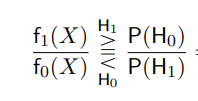


Solving the cross-entropy optimization problem, we estimate a transformation of the likelihood ratio, specifically the following one:
r/(1+r), r = f1/fo   .
Therefore, the threshold can be computed as follows:
thresshold=(P0/p1)/(1+(P0/p1))
where P0,p1 are the a priori probabilities.

In [14]:
zero=len(np.where(train_y==0)[0])
zerov=len(np.where(val_y==0)[0])
one=len(np.where(train_y==1)[0])
onev=len(np.where(val_y==1)[0])
m=max(zero,one)
class_weight={0:m/zero,
              1:m/one}
print(class_weight)

z=zero+zerov
o=one+onev
P0_p1=z/o
thresshold=P0_p1/(1+P0_p1)
thresshold


{0: 1.0, 1: 1.6507936507936507}


0.6161616161616161

In [15]:
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Input,Dropout,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.optimizers.schedules import LearningRateSchedule,ExponentialDecay
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import legacy as keras_legacy_optimizers


checkpoint_callback = ModelCheckpoint(filepath='best_model.h5',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=False,
                                      mode='min',
                                      verbose=1)

class LRSchedule(LearningRateSchedule):
    def __init__(self):
        super(LRSchedule, self).__init__()

    def __call__(self, step):
        return tf.cond(step < 100,
                       lambda: 0.001,
                       lambda: 0.0001)
lr_schedule = LRSchedule()

input=Input((25,))
x=Dense(20,activation="selu")(input)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(10,activation="selu")(x)
x=BatchNormalization()(x)
x=Dropout(0.1)(x)
output=Dense(1,activation="sigmoid")(x)
model=Model(inputs=input, outputs=output)


epochs=500
opt = keras_legacy_optimizers.Adam(learning_rate=1e-3, decay=1e-3 / epochs)
optimizer = SGD(learning_rate=0.001, momentum=0.9)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])
history=model.fit(train_x, train_y,
          validation_data=(val_x,val_y ),
          class_weight=class_weight,
          epochs=epochs,
          batch_size=32,
          callbacks=[checkpoint_callback])



Epoch 1/500
 1/21 [>.............................] - ETA: 20s - loss: 1.8538 - accuracy: 0.2500
Epoch 1: val_loss improved from inf to 0.95543, saving model to best_model.h5
21/21 [==============================] - 1s 16ms/step - loss: 1.5144 - accuracy: 0.3308 - val_loss: 0.9554 - val_accuracy: 0.3004
Epoch 2/500
15/21 [====================>.........] - ETA: 0s - loss: 1.1054 - accuracy: 0.4625
Epoch 2: val_loss improved from 0.95543 to 0.71889, saving model to best_model.h5
21/21 [==============================] - 0s 9ms/step - loss: 1.0947 - accuracy: 0.4790 - val_loss: 0.7189 - val_accuracy: 0.5964
Epoch 3/500
14/21 [===================>..........] - ETA: 0s - loss: 0.8759 - accuracy: 0.5960
Epoch 3: val_loss improved from 0.71889 to 0.60165, saving model to best_model.h5
21/21 [==============================] - 0s 10ms/step - loss: 0.8514 - accuracy: 0.6093 - val_loss: 0.6017 - val_accuracy: 0.6368
Epoch 4/500
12/21 [================>.............] - ETA: 0s - loss: 0.7151 - accur

In [ ]:
model=load_model('best_model.h5')
predict=model.predict(testContinuous)
predict = (predict >thresshold).astype(int).ravel()
submit = pd.DataFrame({"PassengerId":test_data.PassengerId, 'Survived':predict})
print(submit)
submit.to_csv("final_submission.csv",index = False)